In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

import shap
import warnings
warnings.filterwarnings('ignore')


In [52]:
# Set dataset path
data_dir = "PPMI_ds/"

### --- Clinical + Cognitive Modality --- ###
clinical_files = {
    "diagnosis": "Primary_Clinical_Diagnosis_18Mar2025.csv",
    "parkinsonism": "Features_of_Parkinsonism_18Mar2025.csv",
    "rem": "Features_of_REM_Behavior_Disorder_18Mar2025.csv",
    "cgi": "Clinical_Global_Impression__CGI__-_Investigator_18Mar2025.csv",
    "exam": "General_Physical_Exam_18Mar2025.csv"
}

clinical_dfs = {name: pd.read_csv(os.path.join(data_dir, fname)) for name, fname in clinical_files.items()}

# General Physical Exam (pivoted)
exam_df = clinical_dfs['exam'][['PATNO', 'PECAT', 'ABNORM']]
exam_wide = exam_df.pivot_table(index='PATNO', columns='PECAT', values='ABNORM', aggfunc='max')
exam_wide.columns = [f"ABNORM_{str(col).strip().replace(' ', '_')}" for col in exam_wide.columns]
exam_wide.reset_index(inplace=True)

# Diagnosis and label
label_df = clinical_dfs['diagnosis'][['PATNO', 'PRIMDIAG']].drop_duplicates(subset='PATNO')
label_df['label'] = label_df['PRIMDIAG'].apply(lambda x: 1 if x == 17 else 0)
label_df = label_df[['PATNO', 'label']]

# Aggregate cognitive/clinical data
aggregated = []
for key in ['parkinsonism', 'rem', 'cgi']:
    df = clinical_dfs[key].drop(columns=[
        'EVENT_ID', 'INFODT', 'REC_ID', 'PAG_NAME', 'ORIG_ENTRY', 'LAST_UPDATE'
    ], errors='ignore')
    aggregated.append(df.groupby('PATNO').mean(numeric_only=True).reset_index())

# Merge clinical features
clinical_merged = label_df.copy()
for df in aggregated + [exam_wide]:
    clinical_merged = clinical_merged.merge(df, on='PATNO', how='left')

### --- Genetic + Biomarker Modality --- ###
genetic_df = pd.read_csv(os.path.join(data_dir, "iu_genetic_consensus_20250225_18Mar2025.csv"))
variants_df = pd.read_csv(os.path.join(data_dir, "PPMI_PD_Variants_Genetic_Status_WGS_20180921.csv"))
sbr_df = pd.read_csv(os.path.join(data_dir, "DaTScan_SBR_Analysis_18Mar2025.csv"))
diagnosis_df = pd.read_csv(os.path.join(data_dir, "Primary_Clinical_Diagnosis_18Mar2025.csv"))

# Merge all genetic tables
genetic_merged = genetic_df.merge(variants_df, on='PATNO', how='inner')
genetic_merged = genetic_merged.merge(sbr_df, on='PATNO', how='inner')
genetic_merged = genetic_merged.merge(diagnosis_df[['PATNO', 'PRIMDIAG']], on='PATNO', how='inner')

# Clean up columns with excessive missingness and convert binaries
genetic_merged = genetic_merged.dropna(axis=1, thresh=len(genetic_merged) * 0.6)
binary_cols = ['CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER', 'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS']
for col in binary_cols:
    if col in genetic_merged.columns:
        genetic_merged[col] = genetic_merged[col].map({'X': 1, '-': 0})

# Encode categorical columns
non_numeric = genetic_merged.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
genetic_merged[non_numeric] = encoder.fit_transform(genetic_merged[non_numeric])

# Retain PATNO and drop duplicate PRIMDIAG
genetic_merged = genetic_merged.drop(columns=['PRIMDIAG'], errors='ignore')

### --- Merge Both Modalities on PATNO --- ###
final_df = clinical_merged.merge(genetic_merged, on='PATNO', how='inner')

# Final shape and export

final_df = final_df.drop_duplicates()


df_sorted = final_df.sort_values(by=['PATNO', 'DATSCAN_DATE'])  # or 'EVENT_ID'
df_deduped = df_sorted.drop_duplicates(subset='PATNO', keep='first')

leakage_cols = ['PSGLVL'] + [col for col in df_deduped.columns if 'DATSCAN' in col]
df_deduped = df_deduped.drop(columns=leakage_cols)

print("✅ Final combined dataset shape:", df_deduped.shape)
df_deduped.to_csv("PPMI_multimodal_combined.csv", index=False)


✅ Final combined dataset shape: (757, 114)


In [53]:
# Load combined dataset
df = pd.read_csv("PPMI_multimodal_combined.csv")

# Check shape and head
print("Dataset shape:", df.shape)
df.head()

print(list(df.columns))

Dataset shape: (757, 114)
['PATNO', 'label', 'FEATBRADY', 'FEATPOSINS', 'FEATRIGID', 'FEATTREMOR', 'RBDDIAG', 'RBDPSG', 'INVESTAST', 'ABNORM_Abdomen', 'ABNORM_Cardiovascular_(including_peripheral_vascular)', 'ABNORM_Ears/Nose/Throat', 'ABNORM_Eyes', 'ABNORM_Head/Neck/Lymphatic', 'ABNORM_Lungs', 'ABNORM_Musculoskeletal', 'ABNORM_Neurological', 'ABNORM_Other', 'ABNORM_Other_(Specify_location_and_describe)', 'ABNORM_Psychiatric', 'ABNORM_Skin', 'CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER', 'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS', 'APOE', 'PATHVAR_COUNT', 'VAR_GENE', 'LRRK2', 'GBA', 'VPS35', 'SNCA', 'PRKN', 'PARK7', 'PINK1', 'chr1:154925709:G:C_C_PMVK_rs114138760', 'chr1:155235252:A:G_G_GBA_L444P_rs421016', 'chr1:155235843:T:C_C_GBA_N370S_rs76763715', 'chr1:155236246:G:A_A_GBA_T408M_rs75548401', 'chr1:155236376:C:T_T_GBA_E365K_rs2230288', 'chr1:155240629:C:T_T_GBA_IVS2+1_rs104886460', 'chr1:155240660:G:GC_GC_GBA_84GG_rs387906315', 'chr1:205754444:C:T_C_NUCKS1_rs823118', 'chr1:226728377:T

In [54]:
# Define target and features
y = df['label']
X = df.drop(columns=['PATNO', 'label'])

# Drop columns with all missing values (or >50% missing if you prefer)
missing_threshold = 1.0  # use 0.5 for 50% missingness threshold
X = X.loc[:, X.isnull().mean() < missing_threshold]

print("Remaining columns after dropping all-NaN cols:", X.shape[1])


# Impute missing values with KNN
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check for any remaining missing values
print("Remaining NaNs:", X_imputed.isna().sum().sum())


Remaining columns after dropping all-NaN cols: 108
Remaining NaNs: 0


In [55]:
# Print original class distribution
print("Original class distribution:", Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

print("Resampled class distribution:", Counter(y_resampled))


Original class distribution: Counter({0: 566, 1: 191})
Resampled class distribution: Counter({1: 566, 0: 566})


In [63]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define a simple feedforward neural network
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train loop
for epoch in range(15):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


Epoch 1: loss = 0.6638
Epoch 2: loss = 0.5063
Epoch 3: loss = 0.5190
Epoch 4: loss = 0.4456
Epoch 5: loss = 0.3798
Epoch 6: loss = 0.2809
Epoch 7: loss = 0.1408
Epoch 8: loss = 0.3136
Epoch 9: loss = 0.1924
Epoch 10: loss = 0.1265
Epoch 11: loss = 0.1903
Epoch 12: loss = 0.0627
Epoch 13: loss = 0.0579
Epoch 14: loss = 0.1005
Epoch 15: loss = 0.0288


In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set model to evaluation mode
model.eval()

# Predict probabilities on the test set
with torch.no_grad():
    y_proba_tensor = model(X_test_tensor).squeeze()
    y_pred_tensor = (y_proba_tensor >= 0.5).float()  # Threshold at 0.5

# Convert to NumPy
y_proba = y_proba_tensor.numpy()
y_pred = y_pred_tensor.numpy()
y_true = y_test_tensor.numpy()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_proba)

# Print results
print("✅ Model Evaluation Metrics")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")


✅ Model Evaluation Metrics
Accuracy : 0.9588
Precision: 0.9535
Recall   : 0.9647
F1 Score : 0.9591
ROC-AUC  : 0.9904


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


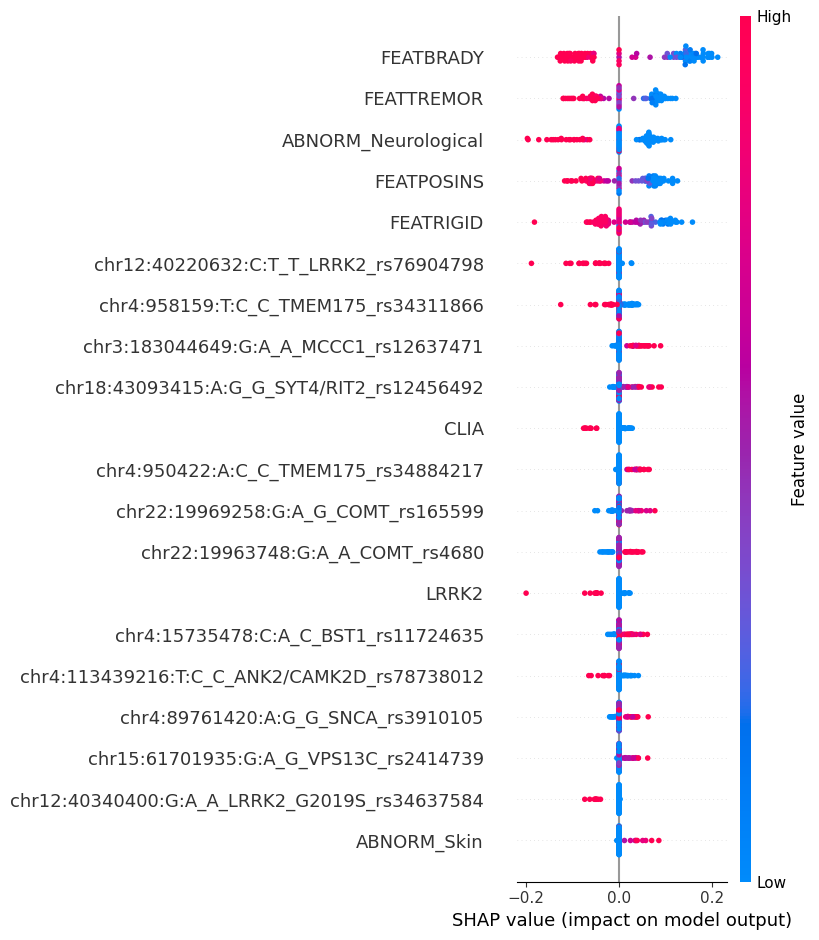

In [68]:
import shap

# Pick a small background sample for efficiency
X_background = X_train.sample(100, random_state=42)
X_background_np = X_background.values

def model_predict(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        preds = model(x_tensor).squeeze().numpy()

        # Ensure shape is always (n_samples,) even if n_samples = 1
        if preds.ndim == 0:
            preds = np.array([preds])
        return preds


# Create SHAP explainer
explainer = shap.KernelExplainer(model_predict, X_background_np)

# Explain a subset of test data
shap_values = explainer.shap_values(X_test.values[:100])

# Summary plot
shap.summary_plot(shap_values, X_test.iloc[:100])
